In [1]:
import matplotlib.pyplot as plt
import numpy as np

from numba import jit

from skimage.io import imread
from skimage.color import rgb2gray

### generate Gaussian kernel

In [2]:
def get_gaussian_kernel(sigma, size=0):
    if size == 0:
        size = int(1 + 2 * np.ceil(sigma * np.sqrt(np.log(400))))
    mid = size // 2
    kernel = np.zeros((size, 1))
    dkernel = np.zeros((size, 1))
    for i in range(size):
        kernel[i] = np.exp(-((i - mid) / sigma) ** 2 / 2)
        dkernel[i] = -(i - mid) / (np.sqrt(2 * np.pi) * sigma ** 3) * kernel[i]
    kernel = kernel / kernel.sum()
    return kernel, dkernel

### padding and convolution

In [3]:
def padding_nearest(img, kernel):
    h, w = img.shape[:2]
    dim = len(img.shape)
    hk, wk = kernel.shape[:2]
    mid_hk, mid_wk = hk // 2, wk // 2
    if dim == 3:
        padded = np.zeros((h + hk - 1, w + wk - 1, 3))
    else:
        padded = np.zeros((h + hk - 1, w + wk - 1))
    padded[:mid_hk, mid_wk:w + mid_wk] = img[0:1, :]  # top
    padded[h + mid_hk:, mid_wk:w + mid_wk] = img[-1:, :]  # bottom
    padded[mid_hk:h + mid_hk, :mid_wk] = img[:, 0:1]  # left
    padded[mid_hk:h + mid_hk, w + mid_wk:] = img[:, -1:]  # right
    padded[:mid_hk, :mid_wk] = img[0, 0]  # top-left
    padded[:mid_hk, w + mid_wk:] = img[0, -1]  # top-right
    padded[h + mid_hk:, :mid_wk] = img[-1, 0]  # bottom-left
    padded[h + mid_hk:, w + mid_wk:] = img[-1, -1]  # bottom-right
    padded[mid_hk:h + mid_hk, mid_wk:w + mid_wk] = img
    return padded


def convolution(img, kernel):
    dim = len(img.shape)
    padded = padding_nearest(img, kernel)
    if dim == 3:
        kernel = np.repeat(kernel[:, :, np.newaxis], 3, axis=2)
    return convolution_numba(img, kernel, padded)


@jit(nopython=True, cache=True)
def convolution_numba(img, kernel, padded):
    h, w = img.shape[:2]
    hk, wk = kernel.shape[:2]
    output = np.zeros(img.shape)
    kernel = np.fliplr(np.flipud(kernel))  # flip upside-down and left-right
    for row in range(h):
        for col in range(w):
            output[row, col] = (padded[row:row + hk, col:col + wk] * kernel).sum(0).sum(0)
    return output

### Harris corner detector

In [4]:
original_img=imread('lena.jpg')

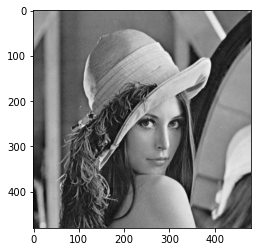

In [5]:
if len(original_img.shape) == 3:
    img = rgb2gray(original_img)
else:
    img = original_img / 255
kernel, d_kernel = get_gaussian_kernel(sigma=1)
plt.imshow(img,cmap='gray')
plt.show()

In [6]:
%%time
# compute derivatives
ix = -convolution(convolution(img, kernel), np.transpose(d_kernel))
iy = convolution(convolution(img, d_kernel), np.transpose(kernel))

CPU times: user 1.14 s, sys: 18.7 ms, total: 1.16 s
Wall time: 1.16 s


In [7]:
# compute Ix^2 Iy^2 and IxIy
ix2=ix**2
iy2=iy**2
ixiy=ix*iy
stacked=np.dstack((ix2,ixiy,iy2))

In [8]:
kernel_int,_=get_gaussian_kernel(sigma=2)

In [9]:
%%time
# convolve with window function
M = convolution(convolution(stacked, kernel_int), np.transpose(kernel_int))

CPU times: user 716 ms, sys: 20.4 ms, total: 736 ms
Wall time: 735 ms


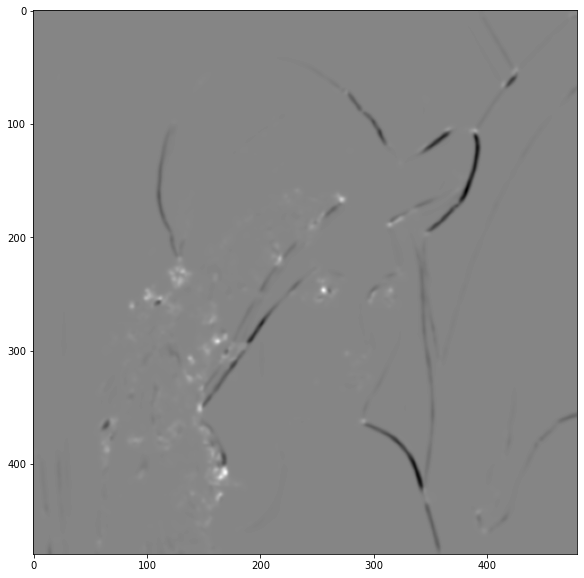

In [10]:
# compute R
k=0.06
R=M[:,:,0]*M[:,:,2]-M[:,:,1]**2-k*(M[:,:,0]+M[:,:,2])**2
R=R/R.max() # normalize to 1

plt.figure(figsize=(10,10))
plt.imshow(R,cmap='gray')
plt.show()

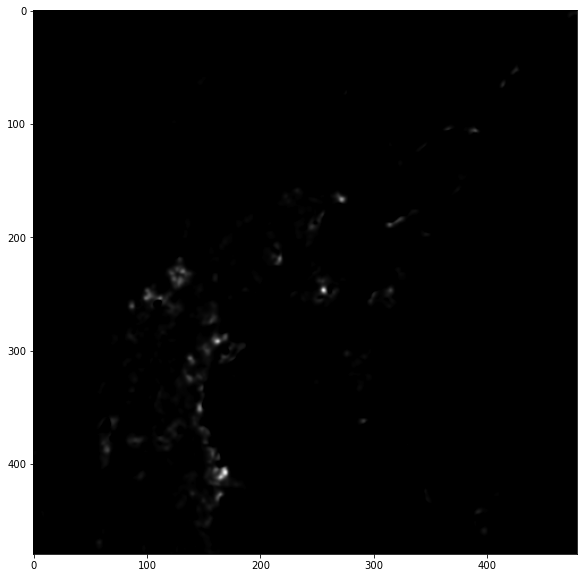

In [11]:
# apply threshold
R[R<0.01]=0

plt.figure(figsize=(10,10))
plt.imshow(R,cmap='gray')
plt.show()

In [12]:
# non-max suppression
corners = []
h, w = R.shape[:2]
for row in range(1, h - 1):
    for col in range(1, w - 1):
        neighbors_max=max(R[row-1, col-1],R[row-1, col],R[row-1, col+1],
                   R[row, col-1],R[row, col+1],
                   R[row+1, col-1],R[row+1, col],R[row+1, col+1])
        if R[row, col]>=neighbors_max and R[row,col]!=0:
            corners.append((row, col))

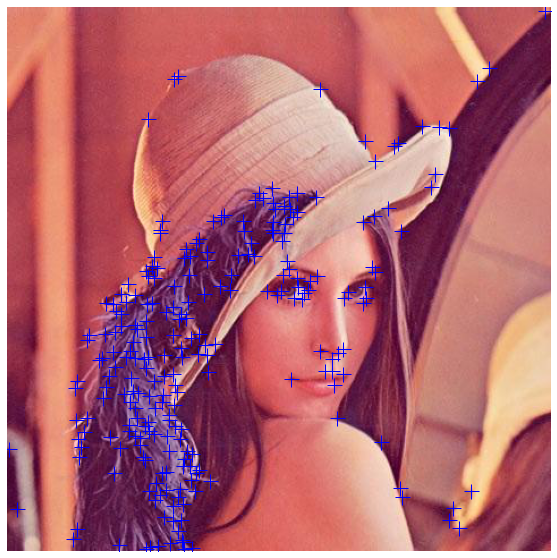

In [13]:
y=[i[0] for i in corners]
x=[i[1] for i in corners]
plt.figure(figsize=(10,10),frameon=False)
plt.imshow(original_img,cmap='gray')
plt.plot(x,y,'+b',markersize=15)
plt.axis('off')
plt.savefig('results.png')
plt.show()